# MCMC in EasyVVUQ

EasyVVUQ provides support for MCMC sampling with multiple chains in parallel.

In [1]:
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
from tqdm.notebook import trange

We define a Rosenbrock function in 2 dimensions for testing purposes. This will be a stand-in for our probability density.

In [2]:
def rosenbrock(inputs):
    x1 = float(inputs['x1'])
    x2 = float(inputs['x2'])
    y = (1.0 - x1) ** 2 + 100.0 * (x2 - x1 ** 2) ** 2
    return {'value': -y}

Next we define a helper function to create a campaign, sample the search space and return the corresponding DataFrame.

In [3]:
def mcmc(tmp_path='.'):
    params = {
        "x1": {"type": "float", "default": 0.0},
        "x2": {"type": "float", "default": 0.0},
        "chain_id": {"type": "integer", "default": 0}
    }
    execute = uq.actions.ExecutePython(rosenbrock)
    actions = uq.actions.Actions(execute)
    
    campaign = uq.Campaign(name='mcmc', work_dir=tmp_path, params=params, actions=actions)    
    
    vary_init = {
        "x1": [-1.0, 0.0, 1.0, 0.5, 0.1],
        "x2": [1.0, 0.0, 0.5, 1.0, 0.2]
    }
    def q(x, b=1):
        return cp.J(cp.Normal(x['x1'], b), cp.Normal(x['x2'], b))
    sampler = uq.sampling.MCMCSampler(vary_init, q, 'value', n_chains=5)
    campaign.set_sampler(sampler)
    iterator = campaign.iterate(mark_invalid=True)
    for _ in trange(1000):
        next(iterator).collate()
    df = campaign.get_collation_result()
    return df

In [4]:
df = mcmc()

  0%|          | 0/1000 [00:00<?, ?it/s]

Finally we plot the the five different chains.

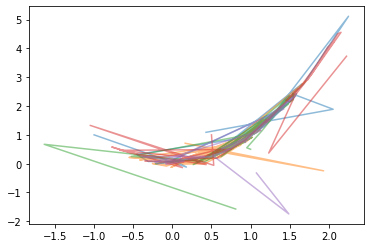

In [5]:
plt.plot(df[(df['chain_id'] == 0).values]['x1'], df[(df['chain_id'] == 0).values]['x2'], alpha=0.5)
plt.plot(df[(df['chain_id'] == 1).values]['x1'], df[(df['chain_id'] == 1).values]['x2'], alpha=0.5)
plt.plot(df[(df['chain_id'] == 2).values]['x1'], df[(df['chain_id'] == 2).values]['x2'], alpha=0.5)
plt.plot(df[(df['chain_id'] == 3).values]['x1'], df[(df['chain_id'] == 3).values]['x2'], alpha=0.5)
plt.plot(df[(df['chain_id'] == 4).values]['x1'], df[(df['chain_id'] == 4).values]['x2'], alpha=0.5)

Finally let us plot a histogram of this data.

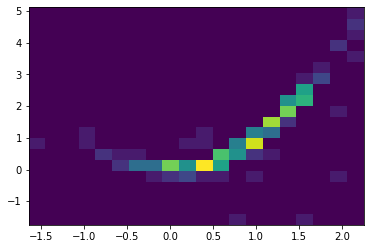

In [6]:
hist = plt.hist2d(df['x1'].T.values[0], df['x2'].T.values[0], bins=20)